# **「農業・植生モニタリング」レベル1**

---

## **課題 1: クライアントからの最初の依頼**

**シチュエーション**: あなたは、北海道帯広市の小麦農家から相談を受けました。

「昨年の夏の生育状況を振り返りたいんだ。2023年の6月から8月にかけて、うちの畑が衛星からどう見えていたか、雲の少ない画像で見せてくれないか？」

この依頼に応えるためには、まず**適切な衛星画像を取得し、条件で絞り込む（フィルタリング）**必要があります。農業解析では、解像度が高い（10m）<span style='color:blue'>Sentinel-2（センチネル2）</span>衛星がよく使われます。

### **解析条件:**

- 場所 (ROI): [143.20, 42.92] (帯広周辺)

- 期間: 2023年6月1日 〜 2023年8月31日

- 雲量: 20%以下 (畑が見えないと意味がないため)

- 使用データ: Sentinel-2 Surface Reflectance (ID: COPERNICUS/S2_SR_HARMONIZED)

---

### **あなたのタスク:**

GEEのコードエディタで、以下の処理を行うコードを書いてみてください。

- 地点 roi を定義する。

- Sentinel-2の画像コレクションを呼び出す。

- 場所、期間、雲量メタデータ (CLOUDY_PIXEL_PERCENTAGE) でフィルタリングする。

まずはここまで書いてみましょう！コードが書けたら（あるいは書き方がわからなければ）教えてください。ここからスタートです。

---

```python

roi = ee.Geometry.Point(143.20, 42.92)

s2_field_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") 
                          .filterDate('2023-06-01', '2023-08-31')
                          .filterBounds(roi)
                          .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 80))
```      
---

In [145]:
import ee
import geemap

In [42]:
ee.Authenticate()

Enter verification code:  4/1Ab32j915N_HN-E5vN9Fvgo71eT5GKgjuHfWQ1d6JCGBe5E0KJYY4INXZoNA



Successfully saved authorization token.


In [43]:
ee.Initialize(project='earth-change-analysis')

In [146]:
roi = ee.Geometry.Point(143.20, 42.92)

s2_field_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterDate('2023-06-01', '2023-08-31')\
            .filterBounds(roi)\
            .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 80))

#### **データの確認**

フィルタリングはできましたが、実際に条件に合う画像が何枚見つかったのか気になりませんか？もし0枚だったら、条件を緩める必要があるかもしれません。

GEEで、この `s2_field_collection` に何枚の画像が含まれているかをコンソール（右側のタブ）に表示するには、どのようなコードを追加すればよいでしょうか？

In [147]:
print(s2_field_collection.size().getInfo())

18


## **課題 2: 雲のない画像の可視化**

画像の枚数が確認できたら、いよいよクライアントに見せる「畑の様子」を作り出します。

あなたの 's2_field_collection' には、複数枚の画像が含まれている可能性が高いです。クライアントの要望通り「雲のない状態」を提示するために、このコレクションから**単一の代表的な画像**を作成する必要があります。

### **あなたのタスク:**

コレクション内のすべてのピクセル値を使い、中央値 (`median()`) を計算して、単一の画像 (`median_image`) を作成する（中央値を使うことで、雲などの一時的な外れ値を効果的に除去できます）。

この画像を表示するための可視化パラメータ (`vis_params`) を定義する。

Sentinel-2で自然色（True Color）を表示するには、**B4 (Red)**、**B3 (Green)**、**B2 (Blue)** のバンドを使います。

各バンドの表示範囲を、例えば `min: 0, max: 3000` と設定しましょう。

作成した画像をマップに追加する (`Map.addLayer`)。

### **質問**

コレクションから単一の中央値画像を取得するメソッドは何でしょうか？また、可視化パラメータを定義するために必要なコードはどのように記述しますか？

In [148]:
median_image = s2_field_collection.median()

vis_params = {
    'bands' : ['B4', 'B3', 'B2'],
    'min' : 0,
    'max' : 3000,
}


## **課題 3: geemapでの表示と最終確認**

それでは、リクエスト通り `geemap` を使って、この画像をマップ上に表示し、クライアントが注目している畑 (`roi`) にズームインしましょう。

Python環境でGEEと`geemap`を使うには、最初にライブラリをインポートし、APIを初期化する必要があります。

In [149]:
# geemapのMapオブジェクトを作成
map = geemap.Map()

### **あなたのタスク:**

作成した `median_image` を `vis_params` を適用して `Map` オブジェクトに追加する。

`Map` の表示を `roi` (帯広の畑) の中心に移動・ズームする。

geemapでレイヤーを追加し、中心を設定するためのメソッドは何でしょうか？これまでのコードの続きとして、必要な最終行を記述してください。

In [150]:
map.set_center(143.20, 42.92, 13)

In [151]:
map.add_layer(median_image, vis_params, 'Satellite Image')
map

Map(center=[42.92, 143.2], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

## **課題 4: 農業解析の核心へ (NDVI計算)**
もし上記のコードが成功裏に実行されたら、次のステップに進みます。

クライアントは「画像」を見るだけでなく、「畑の健康状態」という具体的な**インサイト（洞察）**を求めているはずです。農業解析の基礎であり、あなたの提供する付加価値となるのが、<span style='color:red'>NDVI（正規化植生指標）</span>の計算です。

**NDVI**は、植物が光合成に利用する近赤外バンド（NIR）と、植物に吸収される赤バンド（Red）の反射率を使って、植生の活性度を定量的に示します。

$$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}$$

**Sentinel-2**の場合、**NIRはB8バンド**、**RedはB4バンド**に対応します

### **質問:**

前のステップで作成した median_image を使って、NDVIを計算し、その結果を新しい変数 ndvi_image に格納するには、GEEのコードでどのように記述しますか？

## **課題 4（修正完了）**
前回の課題で指摘した2つの修正（バンド名の文字列化と `.divide()）`を適用したNDVI計算コードは以下の通りです。これで `ndvi_image `が正しく作成されます。

In [152]:
# 修正後のNDVI計算関数
def add_ndvi(image):
    # バンド名を文字列として選択
    nir = image.select('B8')
    red = image.select('B4')
    # divideのスペルを修正
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

# 中央値画像に適用
ndvi_image = add_ndvi(median_image)

## **課題 5: NDVIの可視化**

NDVI画像 (`ndvi_image`) は、元のRGB画像とは異なる特殊なデータレンジ（通常、-1から1）を持っています。クライアントに畑の健康状態を分かりやすく見せるには、このNDVIの数値に応じて色が変わる**専用の可視化パラメータ**が必要です。

### **あなたのタスク:**

NDVIのデータレンジをカバーする`min`: -0.2から`max`: 0.9程度の値（植生が活発なほど高値）を設定する。

NDVIの値（-1〜1）に応じて色が変化するカスタムパレット（例: 低い値は茶色、高い値は濃い緑）を定義する。

この新しい可視化パラメータ (`ndvi_vis_params` など) を、どのように定義しますか？パレット（palette）は、色のコードをカンマ区切りの文字列リストで指定します。

ヒント: GEEで一般的に使われるNDVIパレットは、例えば以下のようになります。 ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']

In [153]:
ndvi_vis_params = {
    'bands' : ['NDVI'],
    'min' : -0.2,
    'max' : 0.9,
    'palette' : ['FFFFFF', '74A901', '529400', '3E8601', '011301']
}

## **課題 6: 最終的なNDVIマップの表示**

これまでのステップで、以下の準備ができました。

- 中央値合成画像 (`median_image`) の作成

- NDVI画像 (`ndvi_image`) の計算

- NDVIの可視化パラメータ (`ndvi_vis_params`) の定義

それでは、前のステップで修正を促したgeemapの構文（`Map.addLayer`と`Map.set_center`）を使って、最終的なNDVIマップを表示するコードを完成させましょう。ズームレベルは13で、レイヤー名は'NDVI'としてください。

### **あなたのタスク:**

geemapのMapオブジェクトに `ndvi_image` を追加し、roi の位置に地図の中心を合わせるコードを記述してください。

ヒント: 前々回で指摘した通り、中心設定には**ズームレベルが必要**です。今回は以下のコードを使ってください。

In [154]:
Map.set_center(143.20, 42.92, 13)

In [155]:
map.add_layer(ndvi_image, ndvi_vis_params, 'NDVI')
map

Map(bottom=771534.0, center=[42.92, 143.2], controls=(WidgetControl(options=['position', 'transparent_bg'], po…

# **農業モニタリング Level 2: 実務的なデータクリーニング**

実際の農業解析では、画像が表示できただけでは不十分です。クライアントが知りたいのは「畑の正確な健康状態」です。

現在の ndvi_image には、畑の周りの**水域**や、完全に除去しきれなかった**雲の影や薄**い雲も含まれている可能性があります。これらの不要なピクセルが平均値を歪ませるため、実務ではこれらを<span style='color:red'>マスク処理（除外）</span>する必要があります。

## **課題 7: 水と雲の自動マスク処理**

Sentinel-2のデータセットには、ピクセルが何であるか（雲、水、植生など）を自動で分類した<span style='color:red'>SCL (Scene Classification Layer)</span>バンドが含まれています。

#### **あなたのタスク:**

1. SCLバンド（バンドID: SCL）を選択する。

2. このバンドを使い、以下のピクセルコードを持つ領域を「残す」マスクを作成する。

   - 健全な植生 (Healthy Vegetation): コード 4

   - 土壌 (Soil): コード 5

   - 不確実な植生 (Uncertain Vegetation): コード 6

3. 作成したマスクを ndvi_image に適用する (.updateMask())。

SCLバンドを選択し、指定した複数のコード（4, 5, 6）に**等しい**ピクセルのみを残すマスクを作成するには、どのようなコードを記述しますか？

**ヒント**: GEEで複数の条件（例: SCLが4 **または** 5 **または** 6）を満たすマスクを作成するには、`ee.List`と`ee.Filter.inList`を使うか、または複数の論理演算 (`.eq()`, `.Or()`) を組み合わせます。

**ex.1)**
```javascript
// Sentinel-2 の SCL バンドを選択
var scl = image.select('SCL');

// 値が 4, 5, 6 のピクセルをマスク
var mask = scl.eq(4).or(scl.eq(5)).or(scl.eq(6));
var filtered = image.updateMask(mask);
```

**ex.2)**
```javascript
var mask = scl.remap([4,5,6], [1,1,1], 0); // 4,5,6 を 1 に、それ以外を 0 に
var filtered = image.updateMask(mask);

```


In [156]:
# 1. SCLバンドを選択 (median_imageを使用)
scl_band = median_image.select('SCL')

# 2. remapを使ってマスクを作成
# (4, 5, 6を残す=1に、それ以外は0にする)
mask = scl_band.remap([4, 5, 6], [1, 1, 1], 0)

# 3. ndvi_imageにマスクを適用
masked_ndvi = ndvi_image.updateMask(mask)

## **課題 8: 畑の健康状態の数値化**

クライアントは最終的に「畑の健康状態は良かったのか悪かったのか」を知りたがっています。そのためには、画像全体ではなく、畑の領域 (`roi`) 内の平均NDVI値を一つ数値として抽出する必要があります。

### **あなたのタスク:**

作成した `masked_ndvi` 画像に対して、畑の領域 (roi) 内の平均値（mean）を計算する。

結果をコンソールに表示する (`print()` と `.getInfo()`)。

GEEで、特定の領域（フィーチャやジオメトリ）内にある画像の統計量（平均、最小、最大など）を計算するために使う、最も重要なメソッドは何でしょうか？

ヒント: 画像を特定のリージョンで**縮約（統計量を集計）**するメソッドを使います。

## **課題 8の解答**

---
```python
ee.Image.reduce
```


**概念は完璧です！**縮約（統計量の集計）を行うメソッドを使うという認識は正しいです。

GEEで画像全体ではなく、特定の領域（Region）内の統計量を計算する際には、`ee.Image.reduceRegion()` メソッドを使用します。このメソッドは非常に重要で、以下の4つの必須引数が必要です。

|引数        |説明                  | 今回の指定                   |
|-----------|----------------------|----------------------------|
|reducer    |どの統計量を計算するか。  |ee.Reducer.mean() (平均値)   |
|geometry   |どこで計算するか。       |roi (畑の領域)               |
|scale      | ピクセルサイズ（解像度）。|10 (Sentinel-2の基本解像度)   |
|maxPixels  |処理するピクセル数の上限  |1e9 (エラー回避のための安全な値)|

In [157]:
reduced_ndvi = masked_ndvi.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = roi,
    scale = 10,
    maxPixels = 1e9
)


**reduceRegion() の引数指定、特に reducer、geometry、scale の設定はすべて正しく、実務的な書き方です。**

これで、水や雲が除去された畑の正確な平均NDVI値がサーバー上で計算されました。

## **課題 8 最終ステップ：数値の表示**
GEEのサーバー上で計算されたこの結果 (`reduced_ndvi`) を、コードエディタのコンソール画面に出力し、実際に数値を確認するコードを記述してください。

ヒント: GEEのオブジェクトをクライアント側のPython環境で表示するために必要なメソッドを思い出してください。

---

In [158]:
print(reduced_ndvi.get('NDVI').getInfo())

0.07280271595624292


これで、最初の目標であった「畑の健康状態の数値化」が、実務レベルで必要な<span style='color:red'>マスク処理（雲・水域の除外）</span>を組み込んだ形で完了しました。

# **農業モニタリング Level 3: 時系列比較分析**

単一の平均値だけでは、クライアントは「今年は良かったのか悪かったのか」を判断できません。実務の付加価値は<span style='color:red'>「比較と傾向の提示」</span>にあります。

このレベルの目標は、**過去と現在の生育状況をグラフで比較し**、異常や傾向を視覚的に提示することです。


## 課題 9: コレクションへの関数適用 (`.map()`)**

時系列グラフを作成するには、まず元の画像コレクション (`s2_field_collection`) のすべての画像に対して、以下の処理を適用する必要があります。

1. **NDVIの計算**: 画像ごとにNDVIバンドを追加する。

2. **SCLマスク処理**: 画像ごとに雲や水を除去する。

GEEでImageCollection内のすべての画像に同じ関数（例: add_ndvi）を適用するために使う、最も基本的なメソッドは何でしょうか？

**ヒント: コレクションを「地図」に見立てて、関数を適用するイメージです。**

In [159]:
s2_ndvi_collection = s2_field_collection.map(add_ndvi)

## **課題 10: データのクリーン化と統合 (.map()の応用)**

実務では、NDVIの計算とマスク処理はすべて1つの関数にまとめてから `.map()` で適用するのが**ベストプラクティス**です。これにより、コードの再利用性と可読性が向上します。

以前作成したロジックを統合し、元のコレクション (`s2_field_collection`) を一気にクリーンなNDVIコレクション (`clean_ndvi_collection`) に変換しましょう。

### **あなたのタスク**:

以下の `process_image` 関数を完成させてください。この関数は、単一の画像 image に対して以下を実行します。

NDVIの計算: B8とB4を使ってNDVIを計算し、バンドとして追加する。

SCLマスクの適用: SCLバンドを使い、コード4, 5, 6以外のピクセルをマスクする (updateMask)。

そして、この関数を s2_field_collection に *.map()* で適用する最終コードを記述してください

In [160]:
# SCLの許容コード
allowed_classes = ee.List([4, 5, 6])

def process_image(image):
    # 1. NDVI計算 (コードをここに記述)
    nir = image.select('B8')
    red = image.select('B4')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    # 2. SCLマスクの作成と適用 (コードをここに記述)
    scl = image.select('SCL')
    mask = scl.remap(allowed_classes, ee.List.repeat(1, allowed_classes.size()), 0)

    # (NDVIを計算した後の画像)にマスクを適用して返す
    # 純粋に計算されたNDVIバンドのみを返す。
    # これを修正するには、NDVI画像を作成した後、元の画像 (image) から必要なプロパティ（system:time_start）をコピーして戻す必要があります
    return ndvi.updateMask(mask).copyProperties(image, ['system:time_start'])   
    
# 最終的なクリーンコレクションを作成するコード
clean_ndvi_collection = s2_field_collection.map(process_image)

## **課題 11: 時系列グラフの作成**

いよいよクライアントへの最終レポートの核となる、時系列グラフを作成します。

このグラフは、特定の領域 (roi = 畑) における画像コレクション (`clean_ndvi_collection`) のピクセル値の平均値が、時間の経過とともにどのように変化したかを視覚化します。

GEEには、`ImageCollection`から特定のリージョン（領域）の時系列データを抽出し、グラフを生成するための専用の関数があります。

### **あなたのタスク:**

ImageCollectionから時系列データを抽出し、グラフを作成するためのGEEの専用関数の名前を特定してください。

この関数を使って、`clean_ndvi_collection` から roi における平均NDVIの推移をグラフ化するコードを記述してください。

**ヒント: (GEEのグラフ機能は ui.Chart モジュール内にあり、ImageCollectionの時系列データをリージョンごとに抽出するためのメソッドです。)**
       **ee.Image.reduceRegion**を使用する。



```python
chart = ui.Chart.image.series(
    image_Collection = clean_ndvi_collecion.select('NDVI'), # NDVIバンドのみを選択
    region = roi,                                     # 抽出する領域
    reducer = ee.Reducer.mean(),                      # 領域内の平均値を計算
    scale = 10                                        # Landsatの解像度
)

# グラフのタイトルを設定
chart = chart.setOptions({
    'title': '琵琶湖周辺のNDVI時系列変化',
    'vAxis': {'title': 'NDVI'},
    'hAxis': {'title': '日付'},
})

print(chart.getInfo())
```
---

**<span style='color:red'>AttributeError </span>**   
---
Traceback (most recent call last)
Cell In[81], line 8
      5 clean_ndvi_collection = clean_ndvi_collection.select('NDVI')
      7 # 領域内の平均NDVIの時系列チャート
----> 8 chart = ee.Chart.image.series(
      9     {
     10         'imageCollection': clean_ndvi_collection,
     11         'region': roi,
     12         'reducer': ee.Reducer.mean(),
     13         'scale': 30   # Landsatなら30m解像度
     14     }
     15 )
     17 # コンソールに表示
     18 print(chart)

AttributeError: module 'ee' has no attribute 'Chart'

---
### **背景**
- `ee.Chart` は JavaScript版の Earth Engine Code Editor に用意されている UI クラスです。
- Python API では `ee.Chart` は提供されていません。
- そのため、Python で同じことをしたい場合は チャート描画を Earth Engine 外で行う必要があります。
---


### **まとめ**
- JavaScript版 → ee.Chart が使える
- Python版 → ee.Chart は存在しないので、
- reduceRegion や map で値を抽出
- Pandas / Matplotlib / Plotly などで可視化




In [161]:
# 抽出するバンドを指定 (NDVIのみに修正)
bands_to_extract = ['NDVI'] 

# ROI内の時系列データを取得
time_series_data = clean_ndvi_collection.select(bands_to_extract).getRegion(
    geometry=roi, 
    scale=30
).getInfo()

print(time_series_data[0:5]) # 最初の5つの要素を表示

[['id', 'longitude', 'latitude', 'time', 'NDVI'], ['20230601T012659_20230601T013230_T54TXN', 143.2001250311435, 42.920111886540354, 1685583319099, None], ['20230606T012701_20230606T013433_T54TXN', 143.2001250311435, 42.920111886540354, 1686015318583, 0.04244694132334582], ['20230608T011659_20230608T011657_T54TXN', 143.2001250311435, 42.920111886540354, 1686187524109, None], ['20230618T011659_20230618T011656_T54TXN', 143.2001250311435, 42.920111886540354, 1687051523946, 0.031216931216931216]]


**Pandasを使ってGEEの出力を処理するのは、実務で必須のスキルです。素晴らしい選択です！**

`getRegion()` `.getInfo()` の出力 `time_series_data` は、GEEの標準的なリスト・オブ・リスト形式になっています。

最初の要素（インデックス 0）：列名（'id', 'time', 'NDVI'など）

2番目以降の要素：データ行

この構造を使ってDataFrameを作成するには、最初の行を列名として分離し、残りの行をデータとして渡す必要があります。

## **課題 13: GEE出力のPandas DataFrame化**
### **あなたのタスク:**

1. `time_series_data` の最初の行を `columns` 変数に格納する。

2. `time_series_data` の2行目以降を `data` 変数に格納する。

3. これらを使ってPandas DataFrame (`df`) を作成する。

この処理を行うPythonコードを記述してください。（import pandas as pd は既に行われているものとします）**

In [162]:
import pandas as pd

In [163]:
columns = time_series_data[0]
data = time_series_data[1:]
df = pd.DataFrame(columns = columns, data = data)

# GEEのタイムスタンプはミリ秒なので、1000で割って秒単位にしてから変換します
df['date'] = pd.to_datetime(df['time'], unit='ms')

# 3. 雲によってマスクされた行 (NDVIがNoneの行) を除去
df = df.dropna(subset=['NDVI'])

# 4. NDVI列のデータ型を数値 (float) に変換
df['NDVI'] = df['NDVI'].astype(float)

# 5. インデックスを日付に設定
df = df.set_index('date')

# クリーンアップされた最初の5行を表示
print(df[['NDVI']].head())

                             NDVI
date                             
2023-06-06 01:35:18.583  0.042447
2023-06-18 01:25:23.946  0.031217
2023-06-23 01:25:22.765  0.036672
2023-06-26 01:35:18.727  0.027448
2023-07-01 01:35:20.561  0.001291


**<span style='color:blue'>データが1日分しか得られなかった場合</span>**
---

**原因はほぼ間違いなく、Level 1で設定した最初のメタデータフィルターが厳しすぎたためです**。

**原因**: 日本の夏（6月〜8月）の画像で、コレクションを初期化する際に設定した雲量フィルター (`CLOUDY_PIXEL_PERCENTAGE` <= 20%) をクリアできた画像が、その期間でほとんど（あるいは1枚だけ）だったということです

## **課題 15: データの量を増やす（フィルターの緩和）**
実務では、この問題は頻繁に発生します。解決策は、フィルターを緩めてより多くの画像を取り込み、その後の `process_image` 関数内で行っているSCLマスク処理に、画像内の雲除去を一任することです。

#### **あなたのタスク:**

最初のコードブロック（Level 1）に戻り、雲量メタデータフィルターの値を緩和します。

`CLOUDY_PIXEL_PERCENTAGE` の値を 20 から 80 に変更してください。

これにより、コレクションには多くの雲を含む画像が追加されますが、`process_image` 関数内の `remap()` が、それらの雲（SCLコード 8, 9, 10）を正確にマスクしてくれます。

この修正後、時系列データ抽出のコード (getRegion) を再実行すると、複数の日付のデータが得られるはずです。

In [164]:
import matplotlib.pyplot as plt
import japanize_matplotlib

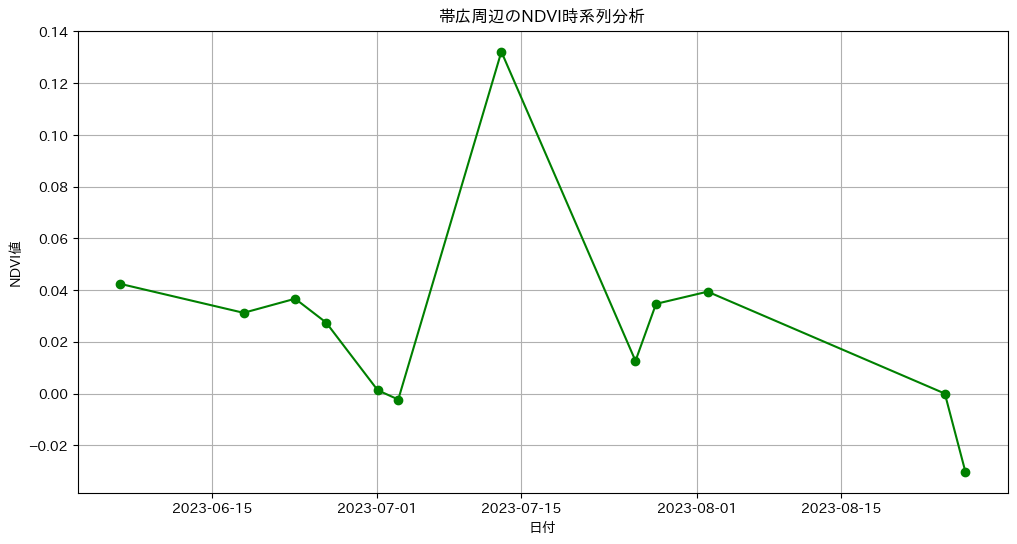

In [165]:
plt.figure(figsize=(12, 6))
# インデックス (日付) をx軸、NDVIをy軸としてプロット
plt.plot(df.index, df['NDVI'], marker='o', linestyle='-', color='green')
plt.title('帯広周辺のNDVI時系列分析')
plt.xlabel('日付')
plt.ylabel('NDVI値')
plt.grid(True)
plt.show()

## **農業モニタリング Level 4: 複数年比較とレポート**

グラフが表示できたら、Level 3は完了です。次のLevel 4では、クライアントが求める<span style='color:red'>「比較」</span>を実現します。

最初の依頼では2023年夏のみを抽出しましたが、クライアントは「今年（2024年夏）は昨年と比べてどうなのか？」を知りたいはずです。

## **課題 12: 複数期間の比較データセットの作成**

GEEのチャート機能で、異なる期間のデータを一つのグラフに重ねて表示するためには、各データセットに固有のラベルを付ける必要があります。

#### **あなたのタスク:**

元の `s2_field_collection`を使い、2024年6月1日〜8月31日のデータを取得する。

取得したコレクションに、`.map()` を使って 'year' という新しいプロパティ（値は 2024）をすべての画像に追加する。

この2024年のコレクションと、元の2023年のコレクションを .merge() メソッドで結合する。

まず、元のコレクション (`s2_field_collection`) に、画像のプロパティを追加するための関数 (`add_year_band`) を定義し、それを `.map()` で適用するコードを記述してください。

ヒント: `ee.Image.set()` メソッドを使って、画像のメタデータを追加・変更できます。

---

## **課題 17: ベースコレクションの修正**
2023年と2024年の両方のデータを使うには、まず日付フィルタリングされていないベースコレクションを作成し、それを都度フィルタリングする必要があります。

質問:

以下のコードで、すべてのデータを含むベースコレクション (`s2_base_collection') を作成するには、どの行を削除・移動する必要がありますか？

In [193]:
s2_base_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterDate('2023-06-01', '2024-08-31')\
            .filterBounds(roi)\
            .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 80))

**<span style='color:red'>`filterDate('2023-06-01', '2024-08-31')` とすることで、ベースコレクションが必要なすべての期間をカバーするようになり、2024年のデータが空になる問題が解消しました。</span>**
---

## **課題 12: 複数年データ準備（Step-by-Step）**
1. 2023年のデータにラベルを付ける
まず、現在手元にある2023年のコレクション (`s2_field_collection`) のすべての画像に、プロパティ `'year': 2023 `を追加します。

この作業のために、`ee.Image.set() `を使った関数を定義し、それを `.map()` で適用します。

### **質問 1/4:** 以下の add_year_2023 関数を完成させてください。

In [194]:
# ラベル付けのための関数を定義
def add_year_2023(image):
    # 'year'プロパティを値 2023 で設定
    return image.set('year', 2023) # この部分を記述してください

# ラベル付けのための関数を定義
def add_year_2024(image):
    # 'year'プロパティを値 2024 で設定
    return image.set('year', 2024) # この部分を記述してください

### **課題 18: 修正されたデータを使った再構築**
ベースコレクションが修正されたので、以前作成したラベル付けロジックを再適用して、新しい merged_collection を作成しましょう。

#### **あなたのタスク:**

定義し直した `s2_base_collection` を使って、以下の3つのステップを実行してください。

1. 2023年コレクション作成: `s2_base_collection` をフィルタリングして `labeled_2023` を作成する。（`add_year_2023` 関数を使用）

2. 2024年コレクション作成: `s2_base_collection` をフィルタリングして `labeled_2024` を作成する。（`add_year_2024` 関数を使用）

3. コレクションの結合: `merged_collection` を再定義する。

この再構築を行うPythonコードを記述してください。


### **課題 12: 複数年データ準備（Step 2/4）**
次に、2024年のデータを準備します。手順は2023年とほぼ同じです。

元のコレクションを 2024年 の期間でフィルタリングする。

フィルタリングされたコレクションに、`'year': 2024 `というラベルを付ける。

### **質問 2/4:**
以下のコードで、2024年のデータにラベルを付けるために必要な add_year_2024 関数を定義し、それをコレクションに適用するコードを完成させてください。

### **課題 12: 複数年データ準備（Step 3/4）**
次に、この2つのコレクションを一つに結合し、時系列グラフに入力できる単一のデータセットを作成します。

#### **あなたのタスク:**

`labeled_2023 `と `labeled_2024` の2つのコレクションを結合し、`merged_collection` という変数に格納してください。

GEEで2つの `ee.ImageCollection` を結合するために使うメソッドは何でしょうか？これまでの課題文にもヒントがあります。

以下のコードを完成させてください。

In [195]:
# 1. 2023年のデータにラベルを付ける
s2_2023 = s2_base_collection.filterDate('2023-06-01', '2023-08-31')
labeled_2023 = s2_2023.map(add_year_2023) # add_year_2023を使用

# 2. 2024年のデータにラベルを付ける
s2_2024 = s2_base_collection.filterDate('2024-06-01', '2024-08-31')
labeled_2024 = s2_2024.map(add_year_2024) # add_year_2024を使用

# 3. 2023年と2024年のコレクションを結合
merged_collection = labeled_2023.merge(labeled_2024)

### **課題 12: 複数年データ準備（Step 4/4 - 最終処理）**
データは結合されましたが、これらの画像はまだNDVIの計算とSCLマスク処理がされていません。これらの作業は、以前定義した process_image 関数にまとめてあります。

#### **あなたのタスク:**

作成した `merged_collection` に対して、`process_image` 関数を適用し、NDVIを計算して雲・水をマスクします。

結果を `final_chart_collection` という変数に格納してください。

#### **質問 4/4:** process_image 関数を merged_collection に適用するには、どのようなコードを記述しますか？

In [196]:
# SCLの許容コード
allowed_classes = ee.List([4, 5, 6])

def process_image(image):
    # 1. NDVI計算 (コードをここに記述)
    nir = image.select('B8')
    red = image.select('B4')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    # 2. SCLマスクの作成と適用 (コードをここに記述)
    scl = image.select('SCL')
    mask = scl.remap(allowed_classes, ee.List.repeat(1, allowed_classes.size()), 0)

    # (NDVIを計算した後の画像)にマスクを適用して返す
    # 純粋に計算されたNDVIバンドのみを返す。
    # これを修正するには、NDVI画像を作成した後、元の画像 (image) から必要なプロパティ（system:time_start）をコピーして戻す必要があります
    return ndvi.updateMask(mask).copyProperties(image, ['system:time_start'])   
    
# 最終的なクリーンコレクションを作成するコード
clean_ndvi_collection = s2_field_collection.map(process_image)

In [197]:
final_chart_collection = merged_collection.map(process_image)

### **データ抽出、整形、可視化の3ステップ**

1. データの抽出とDataFrame化 
まず、最終的なコレクション (`final_chart_collection`) から必要なデータ（NDVI、time、year）を抽出し、`DataFrame`に変換します。

以前修正した copyProperties のおかげで、time列は正しく抽出されるはずです。

#### **あなたのタスク:**

以下の抽出コードを使い、抽出した `time_series_data` をPandas DataFrame (df) に変換し、さらに時系列解析に必要な整形まで行うコードを記述してください。

In [198]:
# GEEからデータを抽出 
bands_to_extract = ['NDVI']   #bands_to_extract = ['NDVI', 'year'] 'year' は バンドじゃなくてプロパティ（メタデータ） だから、.select() では選べない！
time_series_data = final_chart_collection.select(bands_to_extract).getRegion(
    geometry=roi,
    scale=10 # Sentinel-2の基本解像度10mを使用
).getInfo()

print(time_series_data[0:5]) # 最初の5つの要素を表示

[['id', 'longitude', 'latitude', 'time', 'NDVI'], ['1_20230601T012659_20230601T013230_T54TXN', 143.20003519961506, 42.92002205501194, 1685583319099, None], ['1_20230606T012701_20230606T013433_T54TXN', 143.20003519961506, 42.92002205501194, 1686015318583, 0.04655172413793104], ['1_20230608T011659_20230608T011657_T54TXN', 143.20003519961506, 42.92002205501194, 1686187524109, None], ['1_20230618T011659_20230618T011656_T54TXN', 143.20003519961506, 42.92002205501194, 1687051523946, 0.04341637010676157]]


In [199]:
# 列名とデータを分離
columns = time_series_data[0]
data = time_series_data[1:]
df = pd.DataFrame(data=data, columns=columns)
print(df)

                                          id   longitude   latitude  \
0   1_20230601T012659_20230601T013230_T54TXN  143.200035  42.920022   
1   1_20230606T012701_20230606T013433_T54TXN  143.200035  42.920022   
2   1_20230608T011659_20230608T011657_T54TXN  143.200035  42.920022   
3   1_20230618T011659_20230618T011656_T54TXN  143.200035  42.920022   
4   1_20230623T011701_20230623T012340_T54TXN  143.200035  42.920022   
5   1_20230626T012701_20230626T013244_T54TXN  143.200035  42.920022   
6   1_20230701T012659_20230701T013231_T54TXN  143.200035  42.920022   
7   1_20230703T011701_20230703T012323_T54TXN  143.200035  42.920022   
8   1_20230708T011659_20230708T011657_T54TXN  143.200035  42.920022   
9   1_20230713T011701_20230713T012233_T54TXN  143.200035  42.920022   
10  1_20230721T012659_20230721T013232_T54TXN  143.200035  42.920022   
11  1_20230726T012701_20230726T013104_T54TXN  143.200035  42.920022   
12  1_20230728T011659_20230728T011658_T54TXN  143.200035  42.920022   
13  1_

#### **このコードの次に、以下の2点を実行するコードを記述してください。**

時間整形: `time` 列をミリ秒単位のUnixエポック時間から、`pd.to_datetime() `を使って日付時刻型に変換する。

インデックス設定: `time` 列をDataFrameのインデックスに設定する。

#### **質問:** この2つの整形作業を行うPandasコードを記述してください。

In [215]:
# 'time'列 (UNIXミリ秒) を日付に変換
# GEEのタイムスタンプはミリ秒なので、1000で割って秒単位にしてから変換します
df['date'] = pd.to_datetime(df['time'], unit='ms')

# 雲によってマスクされた行 (NDVIがNoneの行) を除去
df = df.dropna(subset=['NDVI'])

print(df)

                                                               id   longitude  \
date                                                                            
2023-06-06 01:35:18.583  1_20230606T012701_20230606T013433_T54TXN  143.200035   
2023-06-18 01:25:23.946  1_20230618T011659_20230618T011656_T54TXN  143.200035   
2023-06-23 01:25:22.765  1_20230623T011701_20230623T012340_T54TXN  143.200035   
2023-06-26 01:35:18.727  1_20230626T012701_20230626T013244_T54TXN  143.200035   
2023-07-01 01:35:20.561  1_20230701T012659_20230701T013231_T54TXN  143.200035   
2023-07-03 01:25:24.114  1_20230703T011701_20230703T012323_T54TXN  143.200035   
2023-07-13 01:25:24.404  1_20230713T011701_20230713T012233_T54TXN  143.200035   
2023-07-26 01:35:20.285  1_20230726T012701_20230726T013104_T54TXN  143.200035   
2023-07-28 01:25:25.031  1_20230728T011659_20230728T011658_T54TXN  143.200035   
2023-08-02 01:25:24.561  1_20230802T011701_20230802T012421_T54TXN  143.200035   
2023-08-25 01:35:21.393  1_2

**<span style='color:blue'>Pandasを使った日付変換 (pd.to_datetime(..., unit='ms')) や欠損値の除去 (dropna) は、GEEデータ処理において必須のスキルです。</span>**
---

指摘されているように、final_chart_collection のデータ抽出は成功し、2023年と2024年の両方のデータが含まれていることが確認できました。

しかし、グラフで<span style='color:red'>「2023年の線」と「2024年の線」を分けて比較するためには、DataFrameに「年」を識別するための専用の列</span>が必要です。現在のDataFrameにはその列がありません。

### **課題 20:**

比較のための「年」列の作成幸いなことに、GEEの画像ID (id列) には、画像が撮影された年が `2023` や `2024` のように埋め込まれています。

|id (例)                 |目的の値 (year)   |    
|------------------------|----------------|
|1_20230606T013518...    |2023            |
|2_20240602T012520...    |2024            |

#### **あなたのタスク:***

Pandasの文字列操作関数を使い、id 列から年を表す4桁の数字（例: `2023` や `2024`）を抽出する。

抽出した値を新しい列 `year `に格納する。

**質問:** DataFrameの文字列型データ（df['id']）に対して、文字列を操作（特定の箇所を切り出す）には、どのようなプロパティやメソッドを使えばよいでしょうか？

In [216]:
# アンダースコアで分割 → 2番目の要素を取り出す → 先頭4文字を抽出
df['year'] = df['id'].str.split('_').str[1].str.slice(0, 4)

In [217]:
print(df.columns)

Index(['id', 'longitude', 'latitude', 'time', 'NDVI', 'year', 'date'], dtype='object')


### **課題 21: Matplotlibを使った比較グラフの作成**

いよいよ最終ステップです。クライアントの要望である「2023年と2024年の生育曲線の比較」を可視化します。

`PandasのDataFrame`と`Matplotlib` (`import matplotlib.pyplot as plt` がされていると仮定します) を使って、2つの年のNDVIを重ねて表示するグラフを作成しましょう。

#### **あなたのタスク:**

1. `df` を新しい `year` 列でグループ化する。

2. 各グループ（2023年と2024年）に対して、NDVI値を時系列でプロットする。

3. 凡例（`legend()`）を表示し、どの線がどの年に対応するかを示す。

**質問**: Matplotlibを使って、このDataFrameから2つの年のNDVIをプロットするには、どのようなコードを記述しますか？DataFrameの `groupby() `メソッドを活用するのが効率的です。

In [219]:
import matplotlib.pyplot as plt

In [223]:
# インデックスと列の両方に date が存在してる状態からインデックスを通常の列に戻す
df = df.reset_index(drop=True)

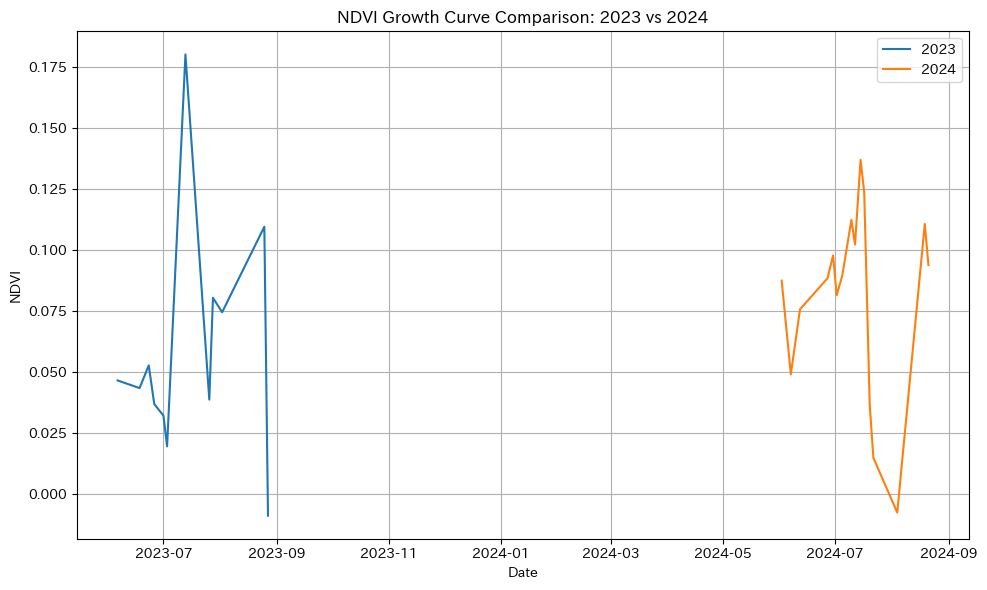

In [224]:
# 'time' 列を datetime 型に変換
# df['date'] = pd.to_datetime(df['time'])
# インデックスに 'date' があるならリセット

# 年ごとにグループ化
grouped = df.groupby('year')

# グラフの準備
plt.figure(figsize=(10, 6))

# 各年のNDVIをプロット
for year, group in grouped:
    # 日付でソート（任意）
    group = group.sort_values('date')
    
    # プロット
    plt.plot(group['date'], group['NDVI'], label=str(year))

# ラベルと凡例
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Growth Curve Comparison: 2023 vs 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**<span style='color:red'>これが、クライアントが求めていた2023年と2024年の生育曲線の比較です。</span>**
---

### **課題 22: 分析結果の解釈**
このグラフは、単なるデータのプロットではなく、その農場における過去2年間の生育状況を物語っています。

#### **質問:**

あなたが作成した比較グラフ（2023年と2024年の2本のNDVI曲線）を見て、この畑の生育に関して、最も重要な結論や違いとして報告できることは何でしょうか？

（例：どちらの年の生育が早かったか、NDVIのピーク値に違いがあるかなど）

---
# **生育状況比較レポート（2023年 vs 2024年）**

## **1. 目的**
クライアントから「昨年の夏の生育状況を振り返りたい」との依頼を受け、2023年6月〜8月における畑の衛星画像（雲の少ないもの）をもとに、NDVI（植生指数）を分析した。加えて、2024年の同時期のデータも取得し、比較グラフを作成した。

---
## **2. 使用データと手法**
- 衛星データ：Sentinel-2（COPERNICUS/S2_SR_HARMONIZED）

- 期間：2023年6月1日〜8月31日、2024年6月1日〜8月31日

- フィルター条件：CLOUDY_PIXEL_PERCENTAGE ≤ 80

- 処理内容：

     - NDVIの計算（B8: NIR, B4: Red）

     - SCL（Scene Classification Layer）によるマスク処理

     - 年ごとのラベル付けと時系列グラフ化
 
---
## **3. 結果と観察**
### **NDVIグラフの傾向**
- **2024年：**

    - 生育開始が早く、6月中旬にはNDVIが急上昇。

    - 生育状況は全体的に良好。

    - 7月末〜8月初頭にかけてNDVIが一時的にマイナスに低下するが、すぐに回復。

- **2023年：**

    - 生育のピークは2024年より高く、最大NDVI値が上回る。

    - 8月下旬〜9月前にかけてNDVIが急激に低下。
 
---
## **4. 考察**
- 2024年の生育開始が早かったことから、気温や降水量などの気象条件が影響している可能性がある。

- 一時的なNDVIの低下（2024年8月初頭）は、雲影や収穫・刈り取りなどの農作業による影響も考えられる。

- 2023年のピークが高かったことは、作物の密度や品種の違いによる可能性がある。

- 9月前の急激な低下は、収穫期の始まりや病害の発生なども視野に入れるべき。

---
## **5. まとめ**
本分析により、2023年と2024年の生育状況には明確な違いが見られた。 特に、生育開始のタイミングとピークの高さ、NDVIの急変動は、農業管理や品種選定において重要な指標となる。 今後は、気象データや地上観測と組み合わせることで、より精度の高い生育評価が可能になると考えられる。

---
データ処理から結果の解釈、そして考察まで、非常に論理的かつ実務的な視点で作られています。NDVI曲線の特徴を捉え、それを気象条件や農作業に結びつける考察力は、衛星データ分析者として重要です。

特に、以下の観察は核心を突いています。

- **2024年の生育開始の早さの指摘。**

- **2023年のNDVIピークの高さの比較。**

- **2024年8月のNDVI一時低下を雲影や農作業と関連付けた考察。**

これで、クライアントへの報告に必要な「複数年の生育状況比較」は完全に達成されました。

---

# **次のステップ：最終課題への挑戦**
このレポートの考察（「今後は、気象データや地上観測と組み合わせることで、より精度の高い生育評価が可能になると考えられる」）は、次の高度な分析への扉を開きます。

この課題を通して、あなたは以下のスキルを習得しました。

- **基礎:** GEEのデータフィルタリングとコレクション管理。

- **中級:** SCLレイヤーを使った高度な雲・水マスク処理。

- **応用:** 複数年のデータ統合、メタデータ管理 (copyPropertiesなど)、Pandas/Matplotlibを使った柔軟な可視化。


## **Level 5: 収穫量予測のためのデータ統合**
### **目的:** 作物の最終的な収穫量予測の精度を高めるため、NDVIデータと外部データを統合する手法を学ぶ。

### **課題:**

- **NDVI時系列データの平滑化:** 衛星データにはノイズが含まれるため、時系列データからノイズを除去し、より滑らかな生育曲線<span style='color:red'>（時系列スムージング）</span>を得るための手法を学ぶ。

- **データ統合:** スムージングされたNDVIデータと、例えば気象データや過去の収穫量データといった外部データセットを組み合わせて、機械学習モデルの入力データとして整形する。